In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyentrp.entropy as ent
from nolitsa.delay import dmi
from nolitsa.dimension import fnn
from mpl_toolkits.mplot3d import axes3d, Axes3D
# from embedding import embed

In [2]:
from unyt import BTU

In [3]:
hh_data = pd.read_excel("https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDd.xls", 
                        sheet_name='Data 1',
                        skiprows=2,
                        parse_dates=True,
                        index_col='Date')
# hh_data = hh_data.resample('H').interpolate(method='linear')
hh_data = hh_data.resample('H').ffill()
hh_data.head()

,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-07 00:00:00,3.82
1997-01-07 01:00:00,3.82
1997-01-07 02:00:00,3.82
1997-01-07 03:00:00,3.82
1997-01-07 04:00:00,3.82


In [4]:
hh_data = hh_data.resample('H').interpolate(method='linear')
# hh_data.isnull().sum()

In [5]:
hh_data

,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-07 00:00:00,3.82
1997-01-07 01:00:00,3.82
1997-01-07 02:00:00,3.82
1997-01-07 03:00:00,3.82
1997-01-07 04:00:00,3.82
...,...
2023-02-13 20:00:00,2.42
2023-02-13 21:00:00,2.42
2023-02-13 22:00:00,2.42


<AxesSubplot:xlabel='Date'>

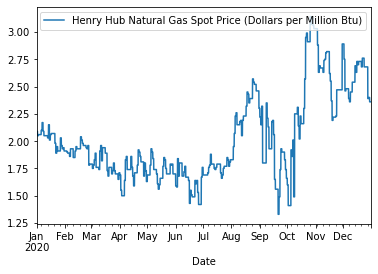

In [6]:
Y = 2020
hh_data[hh_data.index.year==Y].plot()

### Estimate the Time Delay using Delayed Mutual Information (DMI)

In [7]:
hh_data.isnull().sum()

Henry Hub Natural Gas Spot Price (Dollars per Million Btu)    0
dtype: int64

In [8]:
hh_data.iloc[:,0].values

array([3.82, 3.82, 3.82, ..., 2.42, 2.42, 2.42])

In [26]:
sinc = np.sin(np.arange(8760))
ev = np.mean(sinc)
var = np.std(sinc)
print(ev/var**2)

3.307725532077392e-05


(array([1801.,  790.,  641.,  593.,  555.,  554.,  594.,  642.,  789.,
        1801.]),
 array([-9.99993035e-01, -7.99994416e-01, -5.99995798e-01, -3.99997180e-01,
        -1.99998562e-01,  5.60279767e-08,  1.99998674e-01,  3.99997292e-01,
         5.99995910e-01,  7.99994529e-01,  9.99993147e-01]),
 <BarContainer object of 10 artists>)

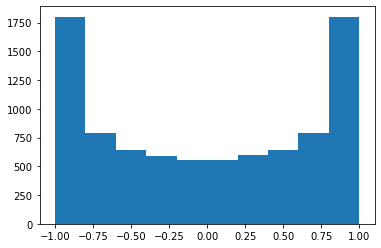

In [27]:
plt.hist(sinc)

In [9]:
# %%timeit
tau_max = 1000
T = np.arange(1,tau_max+1,1)
# DMI = dmi(hh_data.iloc[:,0].values, maxtau=tau_max)
DMI = dmi(np.sin(np.arange(8760)), maxtau=tau_max)
# get the first 10 minima.
minima_indices = np.array(DMI).argsort()[:10]
dmi_minima = np.array([DMI[i] for i in minima_indices])

[680 325 740  30 385 790  80 435 630 985]
[3.61771165 3.61776421 3.61834541 3.61836915 3.61843312 3.64067433
 3.64076077 3.64078431 3.64183236 3.64183713]
The time delay should be T= 680


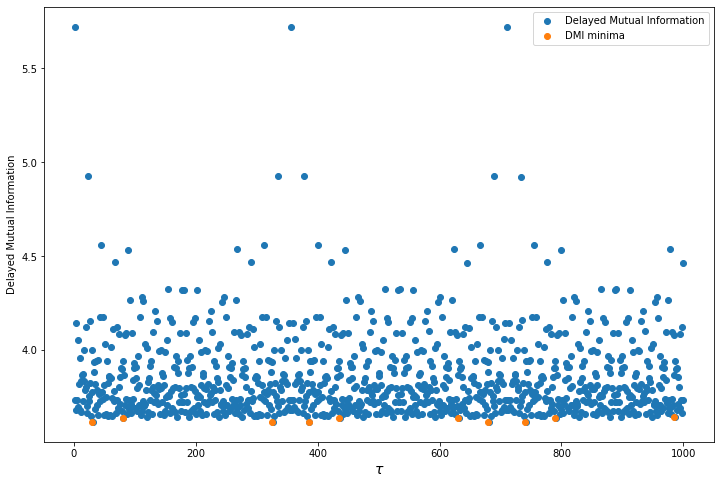

In [10]:
print(minima_indices)
print(dmi_minima)
print(r'The time delay should be T= %.0f'%minima_indices[0])


fig, ax = plt.subplots(figsize=(12,8), facecolor='w')

# plt.figure(figsize=(24, 8))
ax.scatter(T, DMI, label='Delayed Mutual Information')
ax.scatter(minima_indices, dmi_minima, label='DMI minima')
ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel("Delayed Mutual Information")
plt.legend()
# plt.rcParams['text.usetex'] = True
# plt.xticks(T[:20])
plt.show()

### Calculate the Embedding Dimension with False Nearest Neighbors

In [19]:
tau = min(minima_indices)
# tau = minima_indices[0]
dimensions = list(np.arange(1,12,1))

print(f"tau = {tau}")

tau = 30


In [20]:
# a,b,c = fnn(hh_data.iloc[:,0].values, dim=dimensions, tau=tau, maxnum=1000, parallel=True)
a,b,c = fnn(np.sin(np.arange(8760)), dim=dimensions, tau=tau, maxnum=1000, parallel=True)

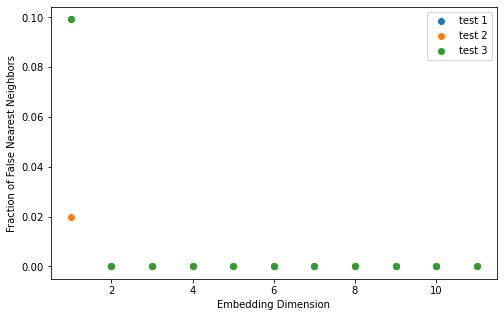

In [21]:
fig, ax = plt.subplots(figsize=(8,5),facecolor='w')
ax.scatter(dimensions, a, label='test 1')
ax.scatter(dimensions, b, label='test 2')
ax.scatter(dimensions, c, label='test 3')
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Fraction of False Nearest Neighbors")
plt.legend()

In [22]:
m = 3

In [23]:
# wp_entropy = ent.weighted_permutation_entropy(time_series=hh_data.iloc[:,0].values, 
#                                               order=m, 
#                                               delay=tau,
#                                               normalize=True)
wp_entropy = ent.weighted_permutation_entropy(time_series=np.sin(np.arange(8760)), 
                                              order=m, 
                                              delay=tau,
                                              normalize=True)
wp_entropy

0.8070035965670026

In [16]:
hh_embed = ent._embed(hh_data.iloc[:,0].values,
                     order=m,
                     delay=tau)

In [ ]:
for a in range(m):
    if a+2 < m:
        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(hh_embed.T[a,:], hh_embed.T[a+1,:], hh_embed.T[a+2,:], s=0.1)
        plt.show()
    else:
        continue